In [46]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy as sp

In [540]:
%run utils.ipynb

In [8]:
import faraway.datasets.sat
sat = faraway.datasets.sat.load()
sat.head()

,expend,ratio,salary,takers,verbal,math,total
0,4.405,17.2,31.144,8,491,538,1029
1,8.963,17.6,47.951,47,445,489,934
2,4.778,19.3,32.175,27,448,496,944
3,4.459,17.1,28.934,6,482,523,1005
4,4.992,24.0,41.078,45,417,485,902


In [10]:
print(faraway.datasets.sat.DESCR)


School expenditure and test scores from USA in 1994-95

Description:

     The ‘sat’ data frame has 50 rows and 7 columns.  Data were
     collected to study the relationship between expenditures on public
     education and test results.

Variables:

     This data frame contains the following columns:

     ‘expend’ Current expenditure per pupil in average daily attendance
          in public elementary and secondary schools, 1994-95 (in
          thousands of dollars)

     ‘ratio’ Average pupil/teacher ratio in public elementary and
          secondary schools, Fall 1994

     ‘salary’ Estimated average annual salary of teachers in public
          elementary and secondary schools, 1994-95 (in thousands of
          dollars)

     ‘takers’ Percentage of all eligible students taking the SAT,
          1994-95

     ‘verbal’ Average verbal SAT score, 1994-95

     ‘math’ Average math SAT score, 1994-95

     ‘total’ Average total score on the SAT, 1994-95

Source:

     "Getting Wha

In [424]:
import faraway.utils

lmod = smf.ols(
    "total ~ expend + salary + ratio + takers",
    data=sat
).fit()
lmod.sumary()

              coefs stderr tvalues pvalues
Intercept 1,045.972 52.870   19.78  0.0000
expend        4.463 10.547    0.42  0.6742
salary        1.638  2.387    0.69  0.4962
ratio        -3.624  3.215   -1.13  0.2657
takers       -2.904  0.231  -12.56  0.0000

n=50 p=5 Residual SD=32.702 R-squared=0.82


Let's **diagnose**.

# Homoscedacity

(<Figure size 1440x504 with 2 Axes>,
 array([<AxesSubplot:xlabel='y.hat', ylabel='e.hat'>,
        <AxesSubplot:xlabel='y.hat', ylabel='sqrt(|e.hat|)'>], dtype=object))

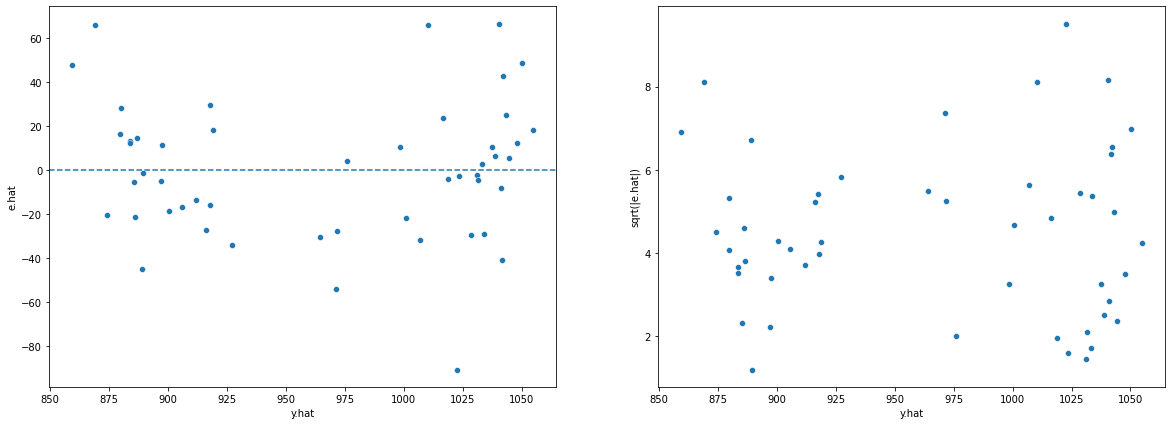

In [425]:
resid_yhat_plot(lmod)

The first plot seems to have problem with unequal variances. </br>
The second one though looks rather OK to me.

In [31]:
ddf = pd.DataFrame({
    "x": lmod.fittedvalues, 
    "y": np.sqrt(np.abs(lmod.resid))
})
smf.ols(
    "y ~ x",
    data=ddf
).fit().sumary()

           coefs stderr tvalues pvalues
Intercept  4.648  4.066    1.14  0.2586
x         -0.000  0.004   -0.04  0.9691

n=50 p=2 Residual SD=1.997 R-squared=0.00


Though this test is rather improper, it still shows there is no statistically significant relation between the fitted values and the residuals. </br>
I've tried some transformations, but none of them seemed to  make situation any better. (the best one: ^(-1/4))

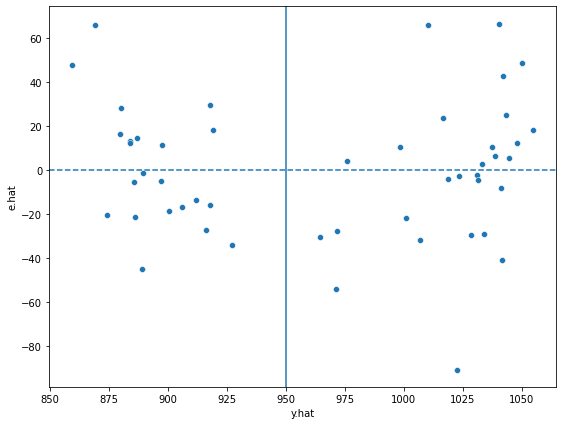

In [427]:
f, ax = resid_yhat_plot(lmod)

ax[0].axvline(950)
ax[1].remove()

Let's test whether those two groups have statistically significant difference in variances

In [535]:
left_group = lmod.resid[lmod.fittedvalues < 950]
right_group = lmod.resid[lmod.fittedvalues > 950]

# f-test
fstat = np.var(left_group, ddof=1) / np.var(right_group, ddof=1)
(1-sp.stats.f.cdf(
    fstat, 
    len(left_group)-1, 
    len(right_group)-1)
)

0.8790540414921537

No statistically significant difference is present. </br></br>
Next -- plot against the predictors; look for the very same patterns.

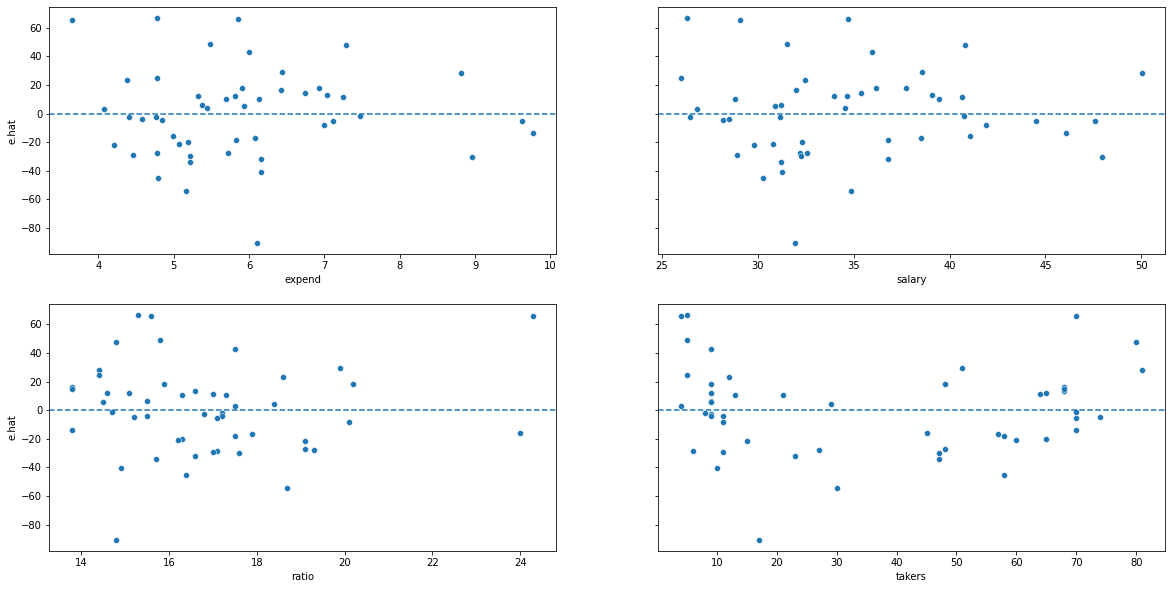

In [538]:
_ = resid_predictors_plot(lmod, figsize=(20, 10))

I haven't found anything suspicious here.

# Normality

Reason for normality checks -- our inferential conclusions (conf int, hyp tests) are dependent on the distribution assumption. </br>
If it is not satisfied, ... </br>
It is not as severe violation as nonconstant variance. That's </br>

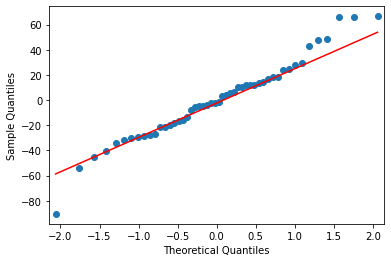

In [440]:
f = sm.qqplot(lmod.resid, line="q")

It is either normal, or a bit long-tailed

<AxesSubplot:ylabel='Count'>

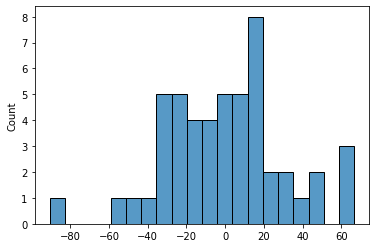

In [67]:
sns.histplot(lmod.resid, bins =20)

In [68]:
sp.stats.shapiro(lmod.resid)

ShapiroResult(statistic=0.9769140481948853, pvalue=0.43038666248321533)

Normality assumption is more or less justified.

In [69]:
sm.stats.durbin_watson(lmod.resid)

2.4524873829581297

### Partial residuals ###

(<Figure size 1440x720 with 4 Axes>,
 array([[<AxesSubplot:xlabel='expend', ylabel='e.hat'>,
         <AxesSubplot:xlabel='salary', ylabel='e.hat'>],
        [<AxesSubplot:xlabel='ratio', ylabel='e.hat'>,
         <AxesSubplot:xlabel='takers', ylabel='e.hat'>]], dtype=object))

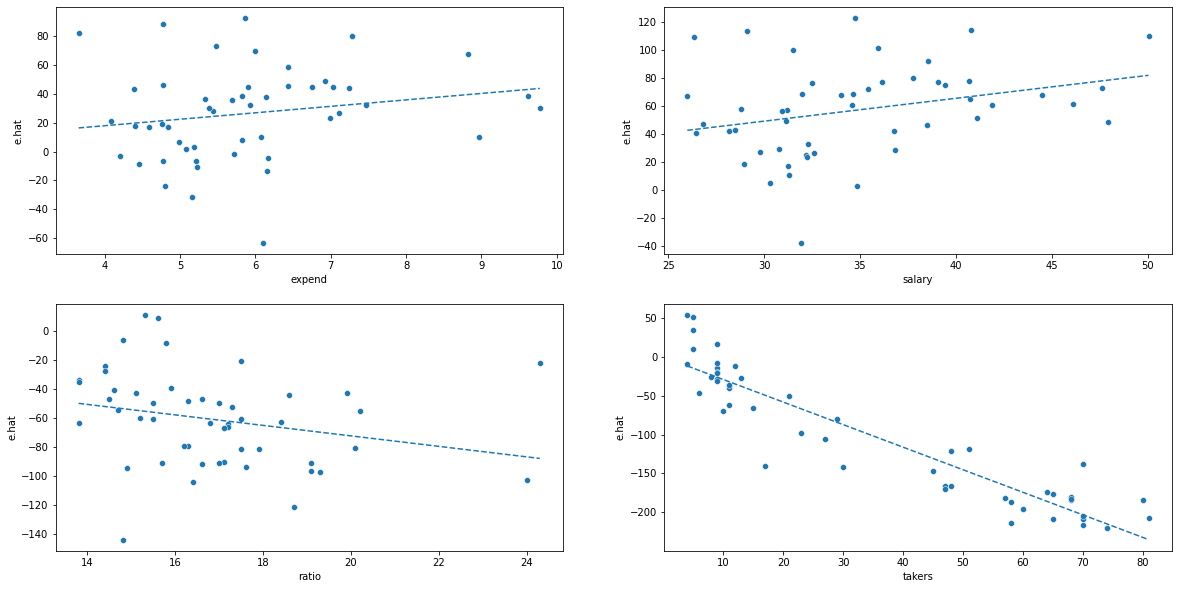

In [451]:
partial_residuals_plot(lmod)

### Partial regression (or added variable) ###

Investigate the "unmixed" relation between $y_i$ and $x_i$. </br>
You see, the usual scatterplot is not representative in this sense </br>
because it also contains the influences from other predictors. </br>
You first get the orthogonal projection of $y$ on $X-x_i$: $y - \hat{y_{(i)}} = \hat{\epsilon_{(i)}}$ </br>
Then you project $x_{i}$ on $X - x_i$. </br>
Finally, you scatter them. </br>
The analysis is then the same as for simple linear regression. </br>
# WHAT ARE WE LOOKING FOR? #
it is useful for both nonlinearity check and search for unusual points detection. </br>


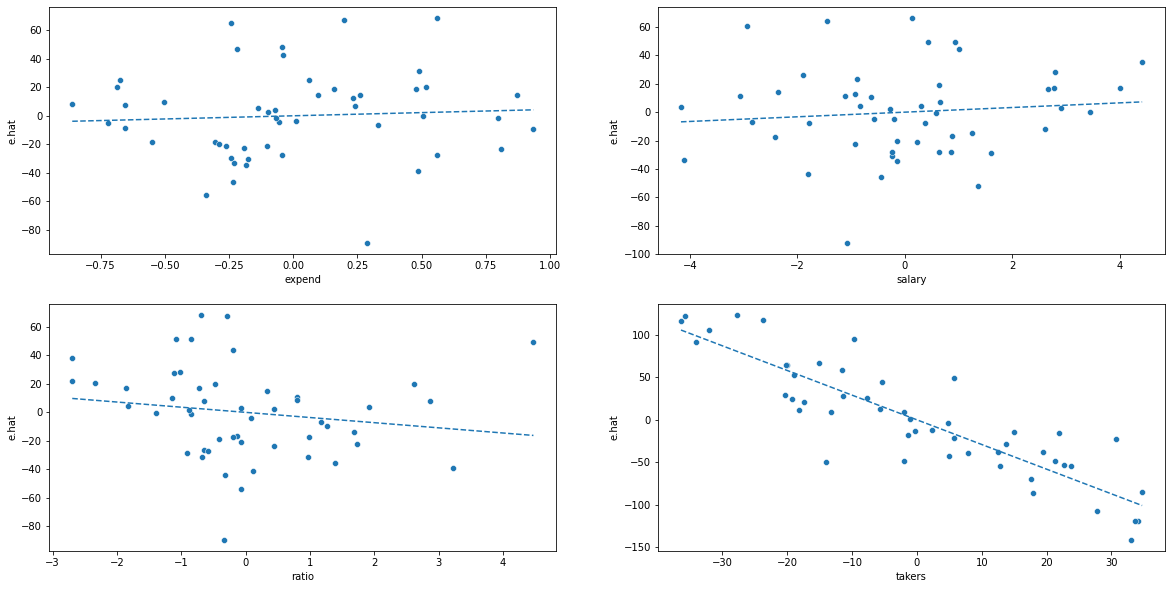

In [539]:
_ = partial_regression_plot(lmod)

These plots looks more or less fine to me

### Leverages ###

In [497]:
n = sat.shape[0]
diagv = lmod.get_influence()
lev = pd.Series(diagv.hat_matrix_diag, sat.index)
treshold = 2 * lmod.params.count() / n
high_lev = lev[lev > treshold].sort_values(ascending=False)
high_lev

43    0.292113
4     0.282118
6     0.225452
29    0.222098
dtype: float64

High leverages (usually more than or equal to $\frac{2p}{n}$) are potential influential points. </br>
We now plot it against the half-normal quantiles and look for points which diverge substantianally from the rest

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

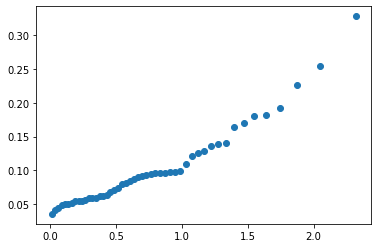

In [484]:
halfqq_plot(lev, to_annotate=[43, 6])

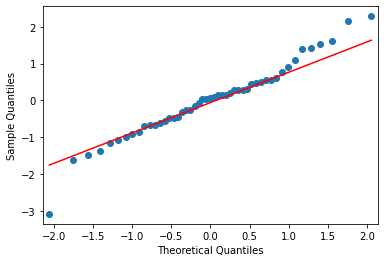

In [485]:
rstandard = diagv.resid_studentized_internal
f = sm.qqplot(rstandard, line="q")

It doesn't look to much different from qqplot for untransformed residuals, except for the y-scale. It is more convenient, because now the y-scale values admit specific interpretation: the values bigger then 3, say, are very unusual.

### Outliers ###

An outlier is a point, whose deviation exceeds the noise. </br>
The idea is to compare the change in the residuals from removing $i$-th observation. </br>

In [277]:
stud = pd.Series(diagv.resid_studentized_external, sat.index)
abs(stud).idxmax(), abs(stud).max()

(47, 3.1244283218107176)

In [281]:
# ppf -- cdf^(-1)
alpha = 0.05
abs(sp.stats.t.ppf(alpha / (2*n), lmod.df_resid))

3.520251464970155

Since $3.12<3.5$, Benferonni tests detects no outliers. </br>
They say it is too conservative, especially for a large $n$. </br>
Well, 3.12 seems l


### Influential observations ###

Cook Statistic 
$$D_i = \frac{(\hat{y} - \hat{y}_{(i)})^{T}(\hat{y} - \hat{y}_{(i)})}{p\hat{\sigma}^2}$$
is a numerical measure for the influence of the $i$-th observation.

43    0.471529
47    0.108140
28    0.079894
33    0.079543
6     0.055748
dtype: float64

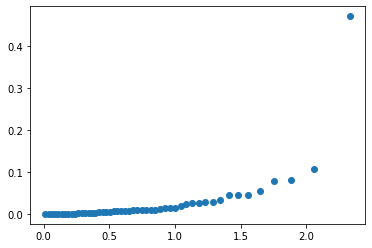

In [506]:
cooks = pd.Series(diagv.cooks_distance[0], sat.index)
halfqq_plot(cooks, to_annotate=[43])
cooks.sort_values(ascending=False).head()

In [489]:
lmod.sumary()

lmod_43 = smf.ols(
    "total~ expend + salary + ratio + takers",
    data=sat.drop(43)
).fit()
lmod_43.sumary()

              coefs stderr tvalues pvalues
Intercept 1,045.972 52.870   19.78  0.0000
expend        4.463 10.547    0.42  0.6742
salary        1.638  2.387    0.69  0.4962
ratio        -3.624  3.215   -1.13  0.2657
takers       -2.904  0.231  -12.56  0.0000

n=50 p=5 Residual SD=32.702 R-squared=0.82
              coefs stderr tvalues pvalues
Intercept 1,093.846 53.423   20.48  0.0000
expend       -0.943 10.192   -0.09  0.9267
salary        3.096  2.328    1.33  0.1904
ratio        -7.639  3.428   -2.23  0.0310
takers       -2.931  0.219  -13.40  0.0000

n=49 p=5 Residual SD=30.901 R-squared=0.84


It seems like the change in coefficients is dramatic. </br>
In order to formally find this, we need to compare it to the changes inflicted by removing other observations. </br>
Fortunately, these "leave-out-one" differences are available to us </br>

In [346]:
# problem -- diagv.dfbetas seems to give a different result
pd.Series(diagv.dfbeta[43], index=lmod.params.index)

Intercept   -47.874437
expend        5.405334
salary       -1.458512
ratio         4.014912
takers        0.026324
dtype: float64

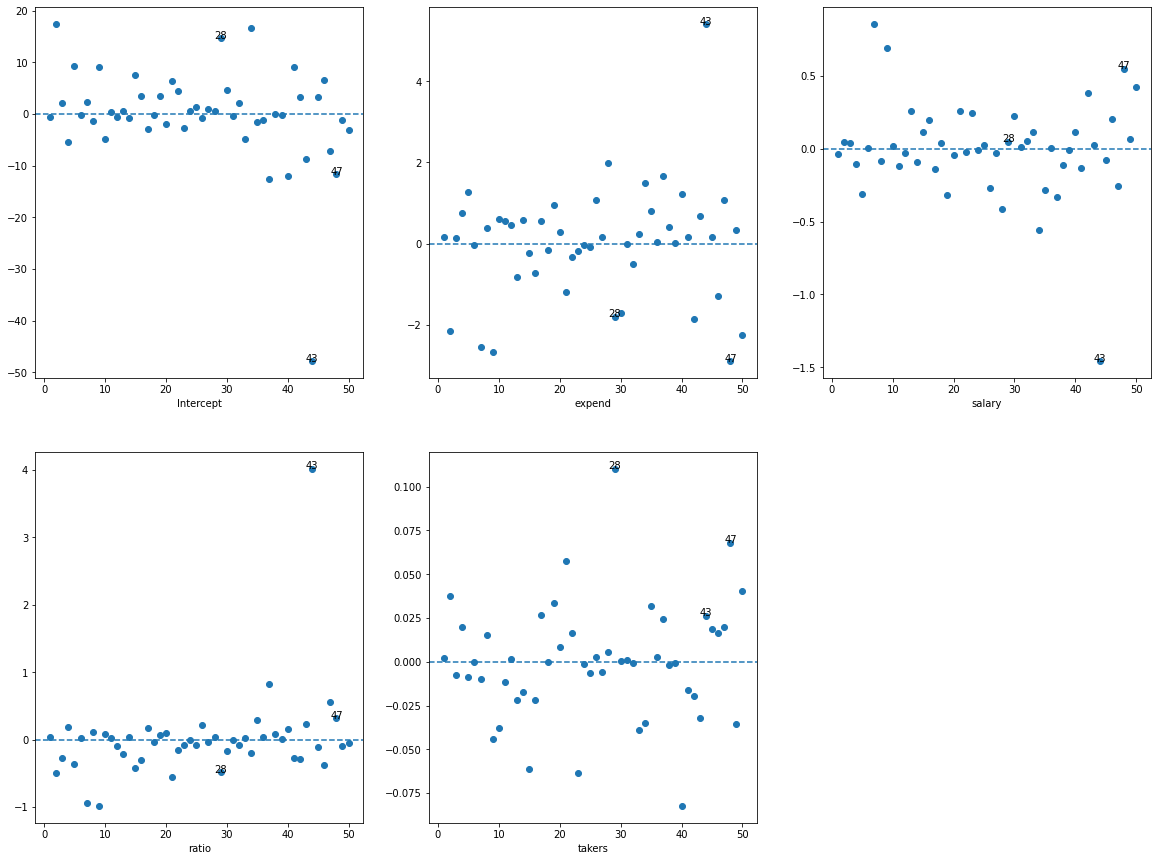

In [542]:
_ = dfbeta_plot(lmod, figsize=(20, 15), to_annotate=[28, 43, 47], in_a_row=3)

Clearly, 43 is influential.

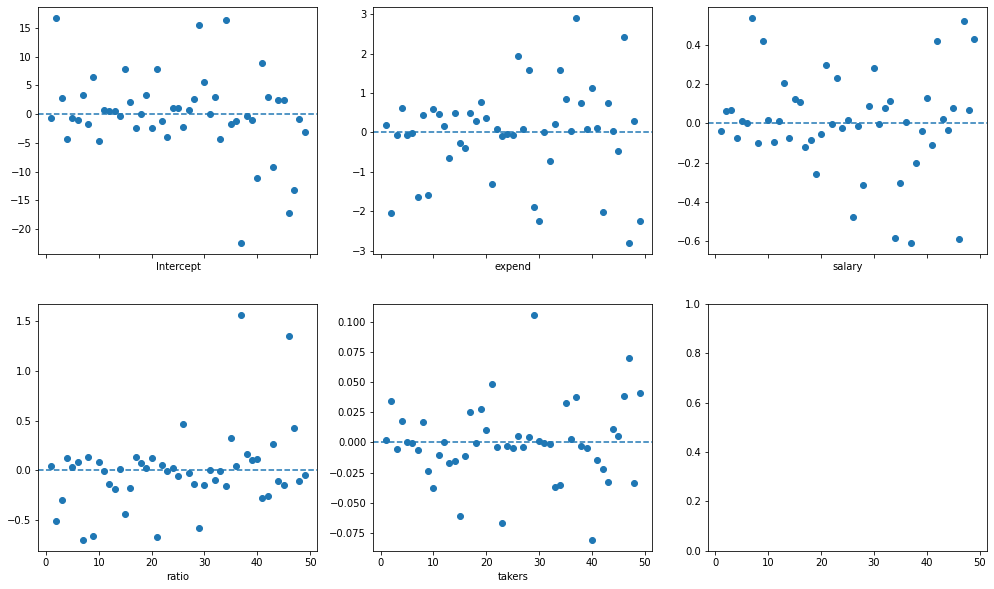

In [543]:
dfbeta = pd.DataFrame(lmod_43.get_influence().dfbeta, columns=lmod_43.params.index)
ix = np.arange(1, dfbeta.shape[0] + 1)

f, ax = plt.subplots(2, 3, figsize=(17, 10), sharex=True)
axs = ax.ravel()

for i, predictor in enumerate(dfbeta.columns):
    ax_i = axs[i]
    ax_i.scatter(ix, dfbeta.loc[:, predictor])
    ax_i.axhline(0, ls='--')
    ax_i.set_xlabel(predictor)    

If we are to remove this observation, or to change the model in any other way, the analysis must be carried out once again. </br>
Thereby diagnostics is an incremental -- w.r.t the chosen perfomance measure: explanatory, predictive features of the model etc.; iterative process.

In [408]:
sat_43 = sat.drop(43)
diagv_43 = lmod_43.get_influence()

Text(0.5, 1.0, 'Old Model')

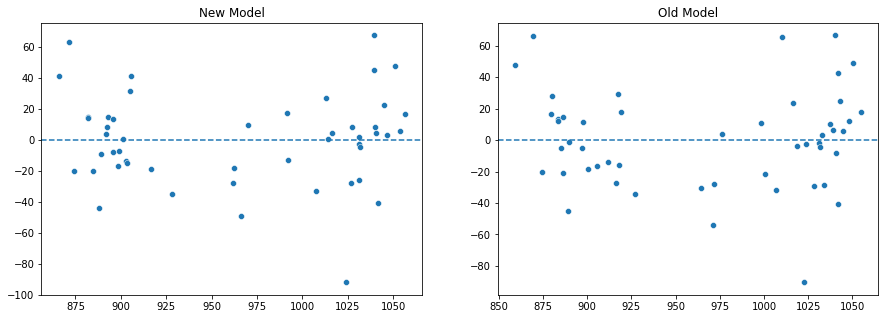

In [403]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=lmod_43.fittedvalues, y=lmod_43.resid, ax=ax[0])
ax[0].axhline(0, ls='--')
ax[0].set_title("New Model")


sns.scatterplot(x=lmod.fittedvalues, y=lmod.resid, ax=ax[1])
ax[1].axhline(0, ls='--')
ax[1].set_title("Old Model")

Text(0.5, 1.0, 'Old Model')

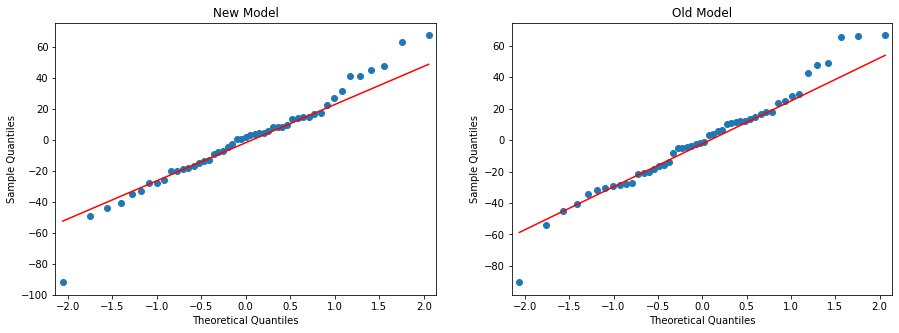

In [406]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))

sm.qqplot(lmod_43.resid, line="q", ax=ax[0])
ax[0].set_title("New Model")

sm.qqplot(lmod.resid, line="q", ax=ax[1])
ax[1].set_title("Old Model")



47    0.126339
33    0.092311
28    0.084250
36    0.056350
39    0.047813
dtype: float64

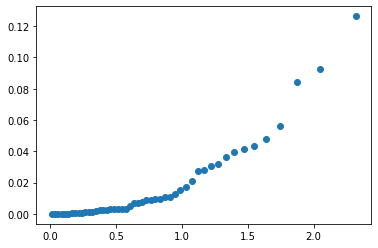

In [410]:
cooks = pd.Series(diagv_43.cooks_distance[0], sat_43.index)
cooks.head()
ix = np.arange(1 , n+1)
halfq = sp.stats.norm.ppf((n+ix)/(2*n + 1))
plt.scatter(halfq, np.sort(cooks))
cooks.sort_values(ascending=False).head()